# How to Penalize a Model?

Regularized models are models that include a penalty term on model complexity to prevent overfitting.
They are commonly used in situations where the number of features exceeds the number of observations, or when features are highly correlated.

Regularization helps the model generalize better by discouraging it from fitting the noise in the training data.
Typical examples include Ridge Regression (L2 regularization) and Lasso Regression (L1 regularization).

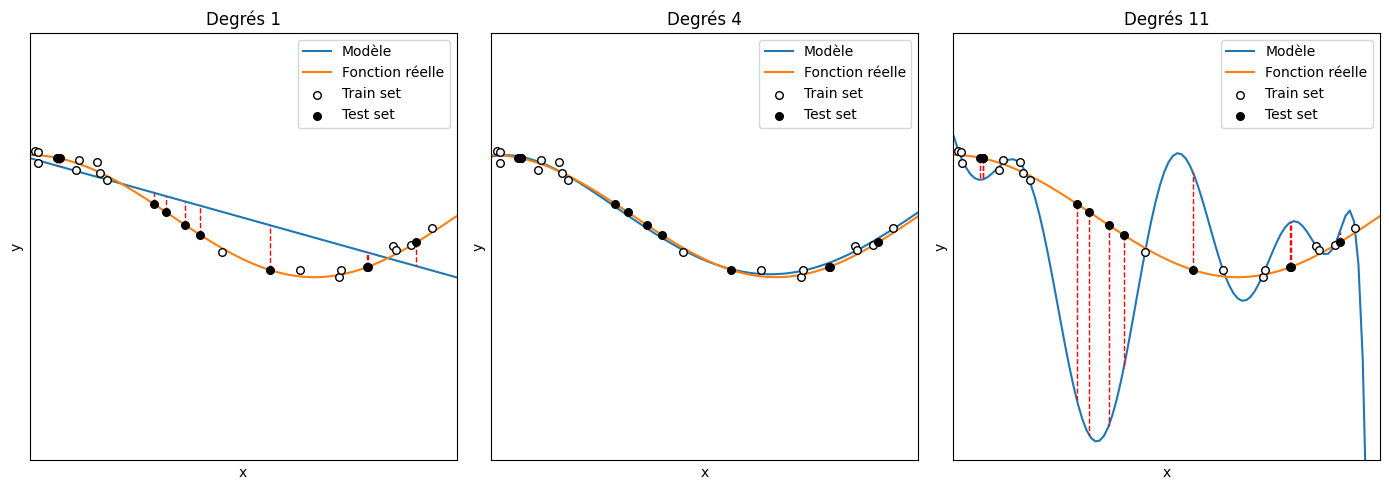

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(11)

n_samples = 20

X = np.sort(np.random.rand(n_samples))
X = X[(X < 0.2) | (X > 0.5)]

# Add the point at x = 0.38
X = np.concatenate([X, [0.45]])

n_samples = len(X)
y = true_fun(X) + np.random.randn(n_samples) * 0.1

degrees = [1, 4, 11]

# Generate test data
n_test_samples = 10
X_test = np.sort(np.random.rand(n_test_samples))
X_test = np.concatenate([X_test, [0.4]])
y_test = true_fun(X_test)

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_plot = np.linspace(0, 1, 100)
    # point to plot
    plt.plot(X_plot, pipeline.predict(X_plot[:, np.newaxis]), label="Modèle")
    plt.plot(X_plot, true_fun(X_plot), label="Fonction réelle")
    plt.scatter(X, y, edgecolor="k", color='w', s=30, label="Train set", zorder=3)
    plt.scatter(X_test, y_test, edgecolor="k", color='k', s=30, label="Test set", zorder=3)

    # Add vertical lines to illustrate the errors
    y_test_pred = pipeline.predict(X_test[:, np.newaxis])
    for x_test, y_test_true, y_test_pred in zip(X_test, y_test, y_test_pred):
        plt.plot([x_test, x_test], [y_test_true, y_test_pred], 'r--', linewidth=1)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-4, 3))
    plt.legend(loc="best")
    plt.title(
        "Degrés {}".format(
            degrees[i]
        )
    )
plt.tight_layout()
plt.show()

In the graph above, we have the following three situations:

- Underfit: the model is too simple to capture the structure of the data. It cannot adapt to the variations in the training data, resulting in poor performance on both training and test sets.

- Good fit: the model is complex enough to capture the structure of the data without overfitting. It achieves good performance on both training and test sets.

- Overfit: the model is too complex and fits the training data too closely, capturing even the noise. It performs well on the training set but poorly on the test set.

## How can we penalize a model?

To penalize a model, we can adjust several parameters, particularly the strength of feature weights!

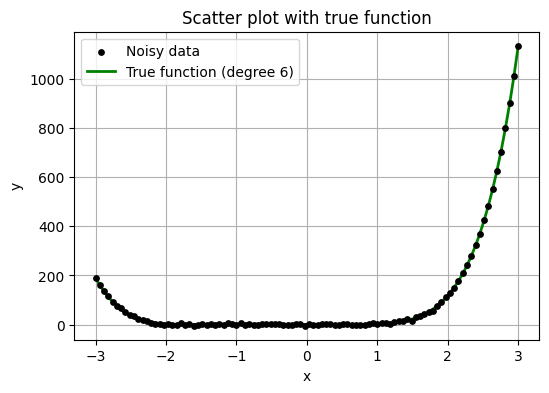

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n = 100

def true_function(x):
    return 1 - 2 * x + 0.5 * x**2 - 0.3 * x**3 + 2 * x**5 + 0.9 * x**6

# Model functions with different levels of "magnitude" of coefficients
def model_nul(x):   # Zero coefficients → underfitting
    return [0] * len(x)

def model_large(x):  # Very large coefficients → overfitting-like
    return 4 - 80 * x + 30 * x**2 - 50 * x**3 + 200 * x**5 + 90 * x**6

X = np.linspace(-3, 3, n)
y_true = true_function(X)
y = y_true + np.random.normal(scale=3, size=n)  # Add noise 

plt.figure(figsize=(6,4))
plt.scatter(X, y, label="Noisy data", color="black", s=15, zorder=3)
plt.plot(X, y_true, label="True function (degree 6)", color="green", linewidth=2)
plt.title("Scatter plot with true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

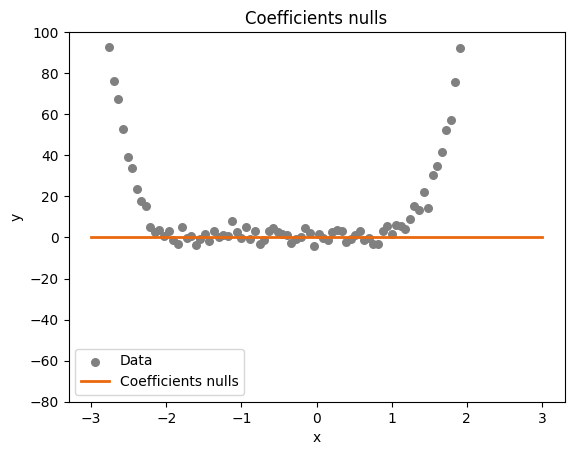

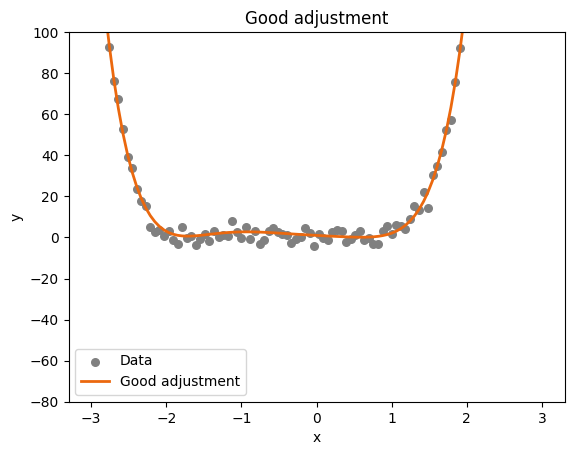

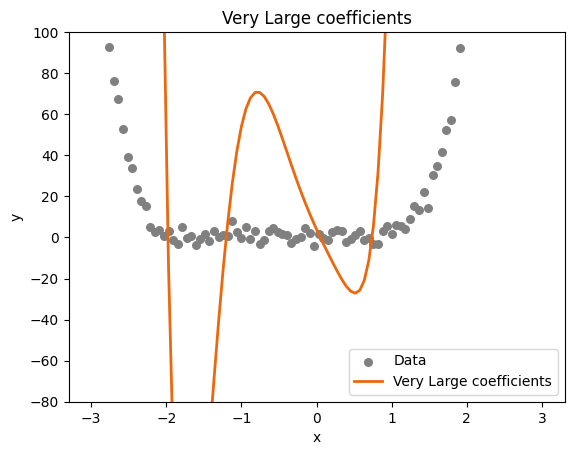

In [3]:
for i, (name, model, color) in enumerate([
    ("Coefficients nulls", model_nul, "#eb680e"),
    ("Good adjustment", true_function, "#eb680e"),
    ("Very Large coefficients", model_large, "#eb680e")
]):
    plt.Figure(figsize=(30, 30))
    plt.scatter(X, y, color="gray", s=30, label="Data")
    plt.plot(X, model(X), color=color, label=name, linewidth=2)
    plt.title(name)
    plt.ylim(-80, 100)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

With smaller coefficients, the model varies less (be careful not to reduce them too much, otherwise you risk underfitting), and if the coefficients become very large, the model fluctuates a lot, tending toward overfitting.

## Ridge

Ridge regularization constrains the coefficients within a circular region. This means that the coefficients are limited in size, but can take any value within this region. Ridge regularization is useful to prevent the coefficients from becoming too large.

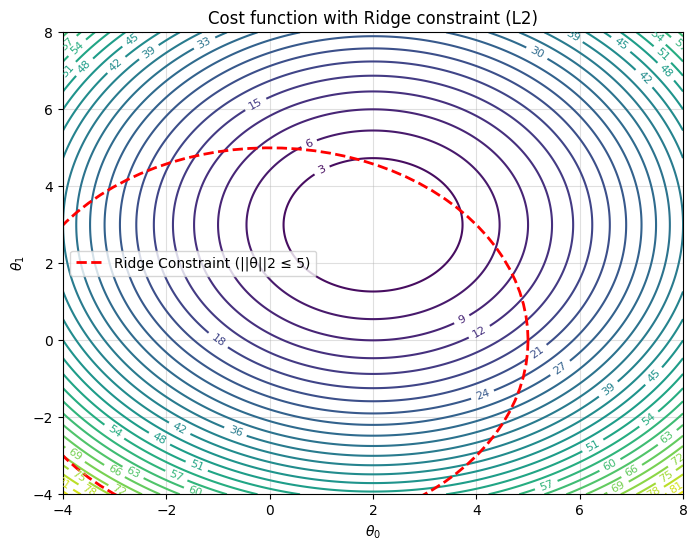

In [4]:
# Parameters range
theta0 = np.linspace(-4, 8, 400)
theta1 = np.linspace(-4, 8, 400)
T0, T1 = np.meshgrid(theta0, theta1)

# Cost function: (theta0 - 2)^2 + (theta1 - 3)^2
cost = (T0 - 2)**2 + (T1 - 3)**2

# Threshold for the constraint
c = 5

# Plotting the Ridge constraint (circle): ||theta||_2 <= c
angles = np.linspace(0, 2 * np.pi, 100)
circle_theta0 = c * np.cos(angles)
circle_theta1 = c * np.sin(angles)

plt.figure(figsize=(8, 6))
contours = plt.contour(T0, T1, cost, levels=30, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)
plt.plot(circle_theta0, circle_theta1, 'r--', linewidth=2, label=f'Ridge Constraint (||θ||2 ≤ {c})')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Cost function with Ridge constraint (L2)')
plt.xlim(-4, 8)
plt.ylim(-4, 8)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

## Lasso

Lasso regularization constrains the coefficients within a diamond-shaped region. This means that the coefficients are limited in size, and some of them can be reduced to zero. Lasso regularization is useful for feature selection, as it can eliminate certain features by shrinking their coefficients to zero.

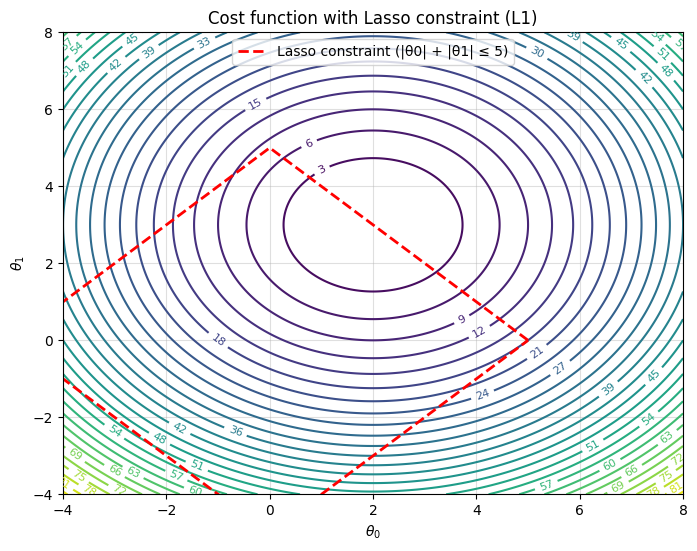

In [5]:
# Parameter grid
theta0 = np.linspace(-4, 8, 400)
theta1 = np.linspace(-4, 8, 400)
T0, T1 = np.meshgrid(theta0, theta1)

# Cost function (simple example)
cost = (T0 - 2)**2 + (T1 - 3)**2

# Threshold for the constraint
c = 5

# Plotting the Lasso constraint (diamond): |theta0| + |theta1| <= c
# The vertices of the diamond are at points (±c, 0) and (0, ±c)
diamond_theta0 = np.array([c, 0, -c, 0, c])
diamond_theta1 = np.array([0, c, 0, -c, 0])

plt.figure(figsize=(8, 6))
contours = plt.contour(T0, T1, cost, levels=30, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)
plt.plot(diamond_theta0, diamond_theta1, 'r--', linewidth=2, label=f'Lasso constraint (|θ0| + |θ1| ≤ {c})')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Cost function with Lasso constraint (L1)')
plt.legend()
plt.grid(alpha=0.4)
plt.xlim(-4, 8)
plt.ylim(-4, 8)
plt.show()


## Elastic Net

Elastic Net regularization combines Ridge and Lasso penalties. It constrains the coefficients within a diamond-like region, but with an additional constraint that prevents them from becoming too large. This allows benefiting from both methods: limiting coefficient size while allowing feature selection.

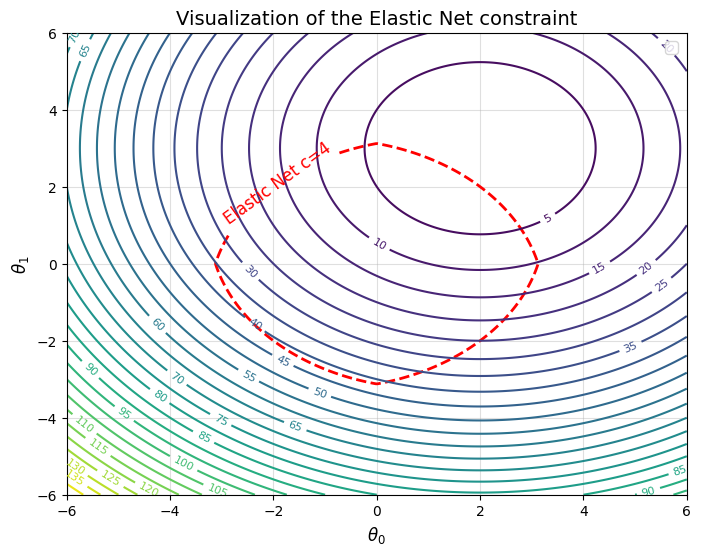

In [6]:
# Parameters for the grid
theta0 = np.linspace(-6, 6, 400)
theta1 = np.linspace(-6, 6, 400)
T0, T1 = np.meshgrid(theta0, theta1)

# Elastic Net parameters
alpha = 0.5  # Weight of the L1 penalty (alpha=1 => Lasso, alpha=0 => Ridge)
c = 4        # Threshold for the constraint

# Define the Elastic Net penalty:
# Elastic Net penalty can be written as:
#   E(theta0, theta1) = alpha*(|theta0| + |theta1|) + (1-alpha)/2*(theta0**2 + theta1**2)
penalty = alpha*(np.abs(T0) + np.abs(T1)) + (1 - alpha)/2*(T0**2 + T1**2)

# Visualize the contour where the penalty equals c
plt.figure(figsize=(8, 6))
# Plot the Elastic Net penalty contour = c
elastic_contour = plt.contour(T0, T1, penalty, levels=[c], colors='r', linestyles='--', linewidths=2)
plt.clabel(elastic_contour, fmt={c: f'Elastic Net c={c}'}, fontsize=12)

# Optional: add contours of a cost function (e.g., quadratic cost)
cost = (T0 - 2)**2 + (T1 - 3)**2
contours = plt.contour(T0, T1, cost, levels=30, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)

plt.xlabel(r'$\theta_0$', fontsize=12)
plt.ylabel(r'$\theta_1$', fontsize=12)
plt.title('Visualization of the Elastic Net constraint', fontsize=14)
plt.grid(alpha=0.4)
plt.legend([f'Elastic Net: α={alpha}, c={c}'], loc='upper right', fontsize=12)
plt.show()
